## 1. Import Library
___

In [1]:
import os
import numpy as np; import pandas as pd

from glob import glob
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

from PIL import Image; import cv2

import torch

import warnings
warnings.filterwarnings('ignore')

### Configuration

In [2]:
class CFG:
    debug = False
    output_dir = 'runs/predict'

    seed = 42
    img_size = [512,512]
    input_format = 'BGR'
    imgdir = '/kaggle/input/gastroscopy-512x512-resized-png'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)

### Install Detectron Library

In [3]:
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.0 MB/s eta 0:00:00


## 2. Utils
___

In [4]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 12.0 MB/s eta 0:00:00


#### Submission Format

In [5]:
def format_pred(labels, boxes, scores):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

#### Submission Decoder

In [6]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

#### Evaluator tool: map-boxes

In [7]:
!pip install -q map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


#### Evaluator tool: pycocotools

In [8]:
!pip install -q pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

## 3. Build Dataset_Dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [9]:
meta_data = pd.read_csv('/kaggle/input/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer


In [10]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [11]:
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-512x512-resized-png/test/*.png')] 
test_df = meta_data[meta_data['image_id'].isin(test_id)]
test_df = test_df.sort_values(by='image_id').reset_index(drop=True)

### Define Dataset_dicts

In [12]:
from detectron2.structures import BoxMode

def get_gastroscopy_dicts(
    imgdir,
    df,
    mode = 'test',
    use_cache=True,
    debug = True,
    target_indices = None
):
    debug_str = f'_debug{int(debug)}'
    cache_path = f'/kaggle/working/dataset_dicts_cache_{mode}{debug_str}.pkl'
    
    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.RED}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/kaggle/input/gastroscopy-512x512-resized-png/{mode}_meta.csv')

       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir, mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,mode,image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           dataset_dicts.append(record)
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)

    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

### Load Dataset_dicts

In [13]:
import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog

In [14]:
DatasetCatalog.register(
    'gastroscopy_test',
     lambda: get_gastroscopy_dicts(CFG.imgdir, test_df, mode='test', debug=CFG.debug)
)

MetadataCatalog.get('gastroscopy_test').set(thing_classes=thing_classes)

namespace(name='gastroscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])

In [15]:
dataset_dicts = DatasetCatalog.get('gastroscopy_test')

#########################
### Creating test Data...
#########################
=> Height of Image: 512
=> Width of Image: 512


Build Dataset Dict: 100%|██████████| 400/400 [00:00<00:00, 22050.91it/s]


## 4. Visualization
___

In [16]:
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode

setup_logger()

gastroscopy_metadata = MetadataCatalog.get('gastroscopy_test')
print(gastroscopy_metadata)

Metadata(name='gastroscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


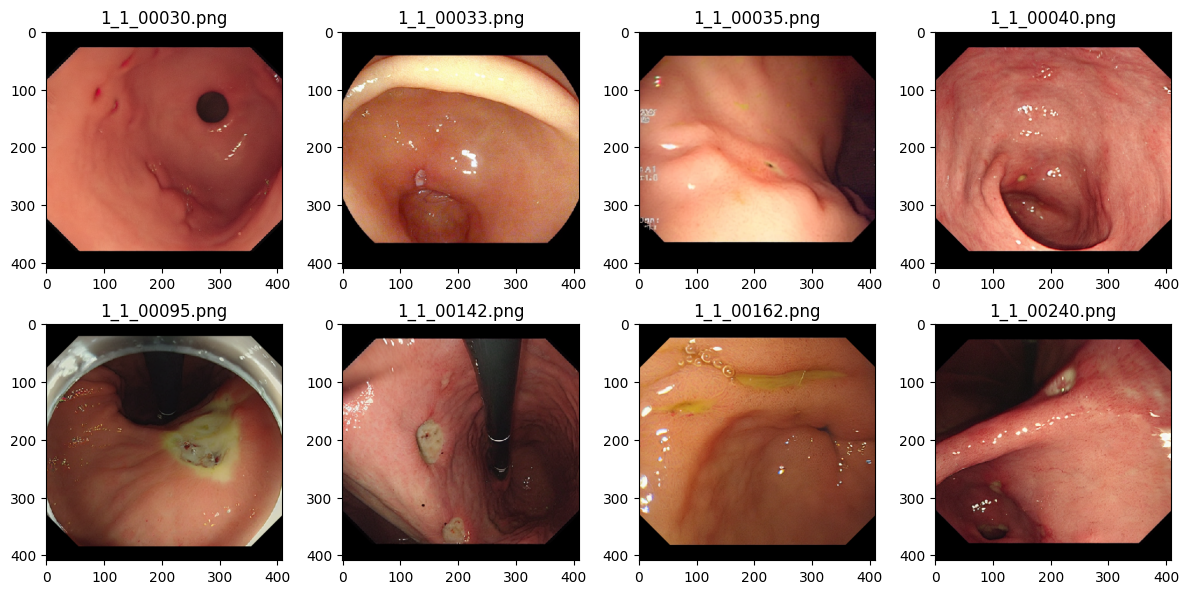

In [17]:
plt.style.use('default')
plt.figure(figsize=(12,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    d = dataset_dicts[i]
    plt.title(d['image_id'])
    img = Image.open(d['file_name']).convert('RGB')
    img = np.array(img)
    visualizer = Visualizer(img, metadata=gastroscopy_metadata, scale=0.8)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    # plt.axis('off')

plt.tight_layout()
plt.show()


## 5. Setting Model Config
___

In [18]:
from detectron2 import model_zoo
from detectron2.config import CfgNode as CN
from detectron2.config import get_cfg

cfg= get_cfg()
cfg.output_dir = CFG.output_dir

cfg.CUDNN_BENCHMARK = False
cfg.INPUT.FORMAT = CFG.input_format
cfg.INPUT.FORMAT = 'BGR'
cfg.INPUT.RANDOM_FLIP = 'none'
cfg.INPUT.MIN_SIZE_TRAIN = (CFG.img_size[0],)
cfg.INPUT.MAX_SIZE_TRAIN = CFG.img_size[0]
cfg.DATASETS.TEST = ('gastroscopy_test',)

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.MODEL.WEIGHTS = '/kaggle/input/gastroscopy-baseline/runs/detect/model_final.pth'
cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.MODEL.FPN.IN_FEATURES = ['res2','res3','res4', 'res5']
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.FPN.FUSE_TYPE = 'sum'
cfg.MODEL.FPN.NORM = ""

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 32, 64, 128, 192, 256, 512]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0]]
cfg.MODEL.ANCHOR_GENERATOR.OFFEST = 0.5

## RPN Options
cfg.MODEL.RPN.IN_FEATURES = ["p2", "p2", "p3", "p4","p4","p5", "p6"]
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3,0.7]
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 384
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = 'ciou'
cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.RPN.POSITIVE_FRACTION = 0.5
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1000
cfg.MODEL.RPN.POST_NMS_TOPK = 1000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 500

## ROI Options
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.IN_FEATURES = ['p2','p3','p4','p5']
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.5
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5]
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = 'ROIAlignV2'
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE = 'ciou'
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION = 28

## Post Processing
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.00 # No More Penalty for adding lower box
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.60
cfg.TEST.DETECTIONS_PER_IMAGE = 100 # 200, 300, 400, 500

print(f"{Fore.BLUE}=> Completed Setting Detectron2's Model Config !")

=> Completed Setting Detectron2's Model Config !


## 6. Preidction Scripts
___

**`DefaultPredictor`**: A simple end-to-end predictor with the given config that runs on single device for a single input image 

=> **But I want to print not single image but batch, So I build predict_batch**

In [19]:
## Examples

###
#   pred = DefaultPredictor(cfg)
#   inputs = cv2.imread('input.jpg')
#   outputs = pred(inputs)

###

In [20]:
from detectron2.engine import DefaultPredictor

## Batch Inference
@torch.no_grad()
def predict_batch(predictor, im_list):
    inputs_list = []
    for original_image in im_list:
        if predictor.input_format == 'RGB':
            original_image = original_image[:,:,::-1]

        height, width = original_image.shape[:2]
        image = original_image
        image = torch.as_tensor(image.astype('float32').transpose(2,0,1))
        image.to(cfg.MODEL.DEVICE)
        inputs = {'image': image, 'height': height, 'width': width}

        inputs_list.append(inputs)
        
    predictions = predictor.model(inputs_list)
    return predictions

In [21]:
test_meta = pd.read_csv('/kaggle/input/gastroscopy-512x512-resized-png/test_meta.csv')
predictor = DefaultPredictor(cfg)

result_list = []
index = 0
batch_size = 8


for i in tqdm(range(int(np.ceil(len(dataset_dicts)/batch_size)))):
    inds = list(range(batch_size * i, min(batch_size * (i+1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d['file_name'], cv2.IMREAD_UNCHANGED) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for j, (im,outputs,d) in enumerate(zip(im_list, outputs_list, dataset_dicts_batch)):
        resized_height, resized_width, ch = im.shape

        #plt.subplot(2,batch_size//2, )

        image_id, height, width = test_meta.iloc[index].values
        
        instances = outputs['instances']
        fields = instances.get_fields()
        
        pred_classes = fields['pred_classes'].cpu().numpy()
        pred_scores = fields['scores'].cpu().numpy()
        pred_boxes = fields['pred_boxes'].tensor.cpu().numpy()

        h_ratio = height / resized_height
        w_ratio = width / resized_width

        pred_boxes[:,[0,2]] *= w_ratio
        pred_boxes[:,[1,3]] *= h_ratio


        result = {'image_id': image_id, 'PredictionString':
                 format_pred(pred_classes, pred_boxes, pred_scores)}
        
        result_list.append(result)
        index += 1
        

[02/08 14:15:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/gastroscopy-baseline/runs/detect/model_final.pth ...


100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


In [22]:
submission_det = pd.DataFrame(result_list, columns=['image_id','PredictionString'])
submission_det.to_csv('/kaggle/working/submission.csv', index=False)
display(submission_det)

,image_id,PredictionString
0,1_1_00030.png,0 0.8589112162590027 1119.544677734375 1281.93...
1,1_1_00033.png,0 0.986071765422821 550.513671875 1133.9954833...
2,1_1_00035.png,0 0.3768001198768616 974.033447265625 1031.952...
3,1_1_00040.png,0 0.9831528067588806 661.5875244140625 1203.64...
4,1_1_00095.png,0 0.9990346431732178 784.8660888671875 494.920...
...,...,...
395,1_3_09783.png,2 0.9989376664161682 101.30267333984375 150.77...
396,1_3_09808.png,2 0.9991612434387207 455.1240234375 250.793823...
397,1_3_09826.png,2 0.9963659048080444 393.27001953125 139.38165...
398,1_3_09872.png,2 0.9996910095214844 85.65924072265625 94.1237...


### Visaulize Predict

[02/08 14:16:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/gastroscopy-baseline/runs/detect/model_final.pth ...


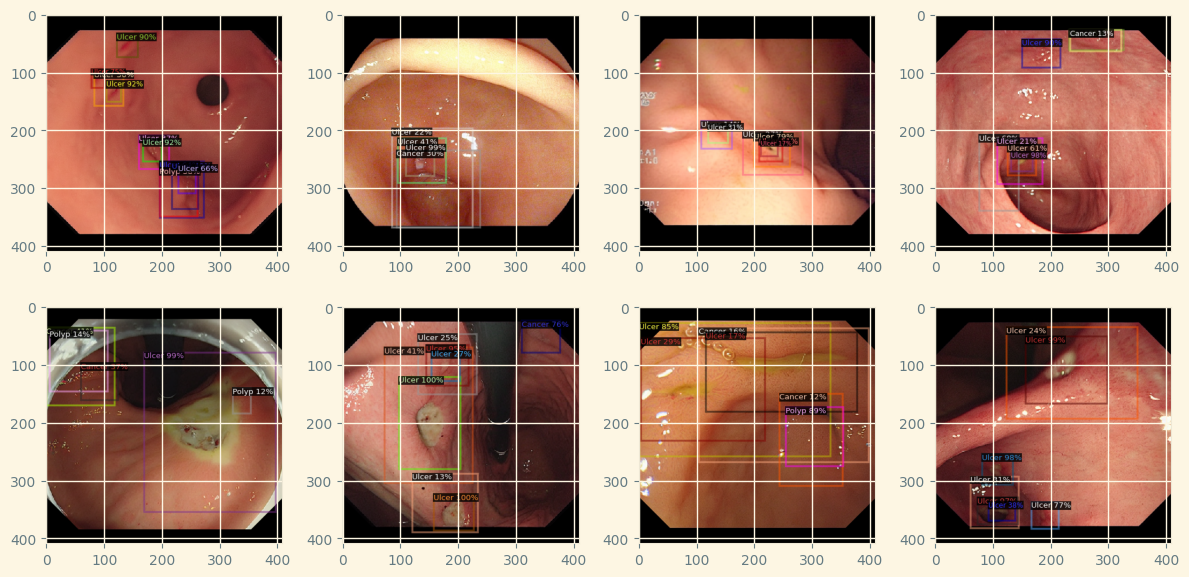

In [23]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 10

pred = DefaultPredictor(cfg)

image_id = test_df['image_id'].unique()

plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    path = f'/kaggle/input/gastroscopy-512x512-resized-png/test/{image_id[i]}'
    inputs = cv2.imread(path)
    outputs = pred(inputs)

    visualizer = Visualizer(inputs[:,:,::-1], metadata=gastroscopy_metadata, scale=0.8)
    out = visualizer.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.imshow(out.get_image())
    # plt.axis('off')
    
    torch.cuda.empty_cache()

plt.tight_layout()
plt.show()

## 6. Evaluate Metric
___

In [24]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 400/400 [00:00<00:00, 2529.87it/s]


### Method 1: map-boxes

In [25]:
ann = test_df.copy()
det = submission_metric.copy()

ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)

Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.531744 |     150
1                              | 0.694576 |     270
2                              | 0.785907 |     231
mAP: 0.670742
Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.195116 |     150
1                              | 0.421993 |     270
2                              | 0.502033 |     231
mAP: 0.373047


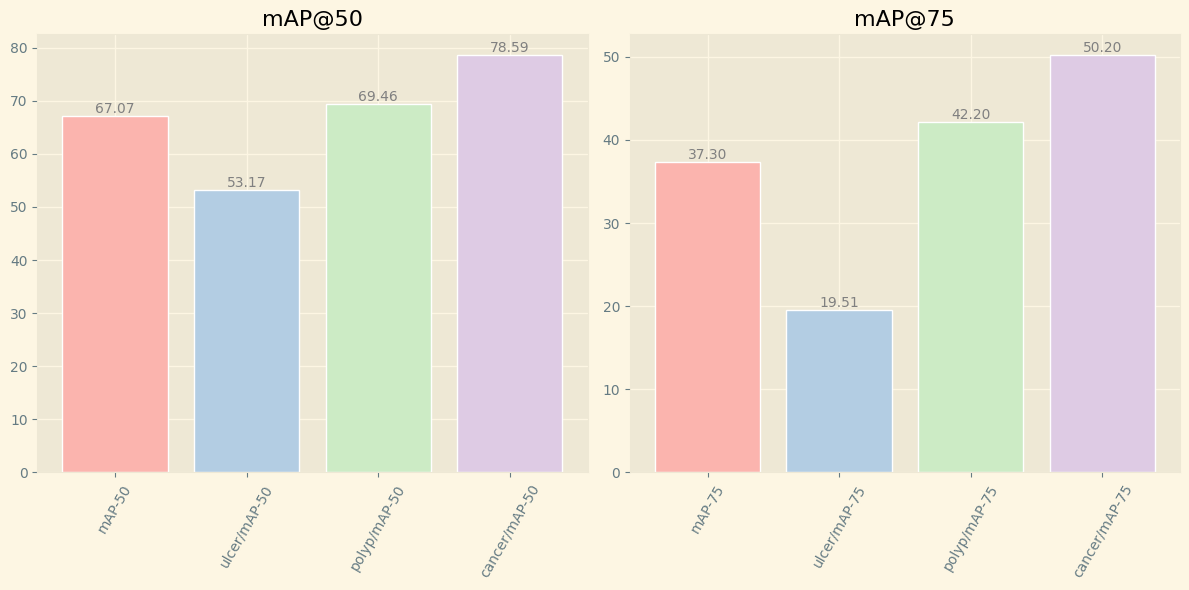

In [26]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('mAP@50')
ax = plt.bar(
    x=['mAP-50', 'ulcer/mAP-50', 'polyp/mAP-50', 'cancer/mAP-50'],
    height = [mean_ap_50*100, average_precisions_50['0'][0]*100,
              average_precisions_50['1'][0]*100, average_precisions_50['2'][0]*100],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    
)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정
plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.title('mAP@75')
ax = plt.bar(
    x=['mAP-75', 'ulcer/mAP-75', 'polyp/mAP-75', 'cancer/mAP-75'],
    height = [mean_ap_75*100, average_precisions_75['0'][0]*100,
              average_precisions_75['1'][0]*100, average_precisions_75['2'][0]*100],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    
)

for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정

plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

### Method2: CoCo-Evaluator

In [27]:
class GastroScopyEval:
    def __init__(self, true_df):
        self.true_df = true_df
        self.image_ids = true_df['image_id'].unique()
        self.annotations = {
            'type': 'instances',
            'images': self.__gen_images(self.image_ids),
            'categories': self.__gen_categories(self.true_df), 
            'annotations': self.__gen_annotations(self.true_df, self.image_ids)
        }
        self.predictions = {
            'images': self.annotations['images'].copy(),
            'categories': self.annotations['categories'].copy(),
            'annotations': None,
        }
    def __gen_categories(self, df):
        print(f'{Fore.GREEN}#'*25)
        print('Generating category data...')
        print(f'#'*25)
  
        cats = df[['lesion', 'lesion_label']]
        cats = cats.drop_duplicates().sort_values(by='lesion_label').values

        results = []
        for cat in cats:
            results.append({
                'id': cat[1],
                'name': cat[0],
                'supercategory': 'none',
            })
        return results

    def __gen_images(self, image_ids):
        print(f'{Fore.GREEN}#'*25)
        print('Generating image data...')
        print('#'*25) 

        results = []
        for idx, image_id in enumerate(image_ids):
            results.append({
                'id': idx,
            })
        return results

    def __gen_annotations(self, df, image_ids):
        print(f'{Fore.GREEN}#'*25)
        print('Generating annotation data...')
        print('#'*25)

        k = 0
        results = []

        for idx, image_id in enumerate(image_ids):
            for i, row in df[df['image_id'] == image_id].iterrows():
                results.append({
                    'id': k,
                    'image_id': idx,
                    'category_id': row['lesion_label'],
                    'bbox': np.array([
                        row['x_min'],
                        row['y_min'],
                        row['x_max'],
                        row['y_max'],
                    ]),
                    'segmentation': [],
                    'ignore': 0,
                    'area': (row['x_max'] - row['x_min']) * (row['y_max'] - row['y_min']),
                    'iscrowd': 0,
                })

                k += 1
        return results 

    def __decode_prediction_string(self, pred_str):
        data = list(map(float, pred_str.split(" ")))
        data = np.array(data)
        return data.reshape(-1,6)
        
    def __gen_predictions(self, df, image_ids):
        print(f'{Fore.GREEN}#'*25)
        print('Generating predictions data...')
        print('#'*25)

        k = 0
        results = []
        for i, row in df.iterrows():
            image_id = row['image_id']
            preds = self.__decode_prediction_string(row['PredictionString'])

            for j, pred in enumerate(preds):
                results.append({
                     'id': k,
                     'image_id': int(np.where(image_ids == image_id)[0]),
                     'category_id': int(pred[0]),
                     'bbox': np.array([
                         pred[2], pred[3], pred[4], pred[5],
                     ]),
                     'segmentation': [],
                     'ignore': 0,
                     'area': (pred[4] - pred[2]) * (pred[5] - pred[3]),
                     'iscrowd': 0,
                     'score': pred[1],  
                })
                k += 1
        return results

    def evaluate(self, pred_df):
        if pred_df is not None:
            self.predictions['annotations'] = self.__gen_predictions(pred_df, self.image_ids)

        coco_ds = COCO()
        coco_ds.dataset = self.annotations
        coco_ds.createIndex()
        coco_dt = COCO()
        coco_dt.dataset = self.predictions
        coco_dt.createIndex()

        imgIds = sorted(coco_ds.getImgIds())
            
        cat_ids = sorted(coco_ds.getCatIds(catNms=self.true_df['lesion'].unique()))
        cocoEval = COCOeval(coco_ds, coco_dt, 'bbox')
        cocoEval.params.maxDets = [1, 100, 100]
        cocoEval.params.imgIds = imgIds
        cocoEval.params.useCats = True
        cocoEval.params.iouType = 'bbox'
        cocoEval.params.iouThrs = np.linspace(0.5, 0.95, 10)
        cocoEval.params.catIds = cat_ids

        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        return cocoEval


In [28]:
gastro_eval = GastroScopyEval(test_df)


cocoEvalRes = gastro_eval.evaluate(submission_det)

#########################
Generating image data...
#########################
#########################
Generating category data...
#########################
#########################
Generating annotation data...
#########################
#########################
Generating predictions data...
#########################
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.03s).
Accumulating evaluation results...
DONE (t=0.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.523
